In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.ExcelFile('/Users/user/desktop/LoanStats3a.xlsx')
df1 = data.parse(0)
df1.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,pub_rec_bankruptcies,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,met_credit_policy
0,NaN,NaN,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,...,2018-08-01,0.0,N,NaT,NaN,NaT,NaN,NaN,NaN,Y
1,NaN,NaN,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,...,2016-10-01,0.0,N,NaT,NaN,NaT,NaN,NaN,NaN,Y
2,NaN,NaN,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,...,2017-06-01,0.0,N,NaT,NaN,NaT,NaN,NaN,NaN,Y
3,NaN,NaN,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,...,2016-04-01,0.0,N,NaT,NaN,NaT,NaN,NaN,NaN,Y
4,NaN,NaN,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,...,2018-04-01,0.0,N,NaT,NaN,NaT,NaN,NaN,NaN,Y


# Cleaning Data

In [105]:
# filling in member id column
member_id_entries = list(range(1,42536))
df1['member_id'] = member_id_entries
df1 = df1.set_index('member_id')

In [106]:
# Deleting columns with vague data
del df1['id'] # Replaced with member id
del df1['title']
del df1['emp_title']
del df1['desc']
# Settlements are post loans and can't be used for prediction of a loans that preceeds settlement. 
del df1['debt_settlement_flag']
del df1['debt_settlement_flag_date']
del df1['settlement_status']
del df1['settlement_date']
del df1['settlement_amount']
del df1['settlement_percentage']
del df1['settlement_term']
del df1['met_credit_policy']
# Deleting datetime
del df1['earliest_cr_line']
del df1['last_pymnt_d']
del df1['last_credit_pull_d']
# Irrelavent columns deleted 
del df1['pymnt_plan']
del df1['initial_list_status']
del df1['issue_d']
del df1['recoveries']
del df1['zip_code']
del df1['addr_state']
del df1['total_pymnt_inv']
del df1['total_rec_late_fee']
del df1['collection_recovery_fee']
del df1['last_pymnt_amnt']
del df1['sub_grade']
del df1['mths_since_last_delinq'] # over half of data missing
del df1['mths_since_last_record'] # over half of data missing 

In [107]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 1 to 42535
Data columns (total 25 columns):
loan_amnt               42535 non-null int64
funded_amnt             42535 non-null int64
funded_amnt_inv         42535 non-null float64
term                    42535 non-null object
int_rate                42535 non-null float64
installment             42535 non-null float64
grade                   42535 non-null object
emp_length              41423 non-null object
home_ownership          42535 non-null object
annual_inc              42531 non-null float64
verification_status     42535 non-null object
loan_status             42535 non-null object
purpose                 42535 non-null object
dti                     42535 non-null float64
delinq_2yrs             42506 non-null float64
inq_last_6mths          42506 non-null float64
open_acc                42506 non-null float64
pub_rec                 42506 non-null float64
revol_bal               42535 non-null int64
revol_util 

In [108]:
# list of columns with na's
df1.columns[df1.isna().any()].tolist()

['emp_length',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'pub_rec_bankruptcies']

In [109]:
# filling missing data according to what makes most sense on a case by case basis. 
df1['annual_inc'] = df1['annual_inc'].fillna(value=df1.annual_inc.mode())
df1['delinq_2yrs'] = df1['delinq_2yrs'].fillna(value = df1.delinq_2yrs.mode())
df1['open_acc'] = df1['open_acc'].fillna(value = df1.open_acc.median())
df1['delinq_2yrs'] = df1['delinq_2yrs'].fillna(value = 0)
df1['pub_rec'] = df1['pub_rec'].fillna(value = df1.pub_rec.mean())
df1['revol_util'] = df1['revol_util'].fillna(value = df1.revol_util.mean())
df1['total_acc'] = df1['total_acc'].fillna(value = df1.total_acc.mean())
df1['emp_length'] = df1['emp_length'].fillna(method = 'ffill')
df1['inq_last_6mths'] = df1['emp_length'].fillna(value=1)
df1['pub_rec_bankruptcies'] = df1['emp_length'].fillna(method = 'ffill')
df1['annual_inc'] = df1['annual_inc'].fillna(value=df1.annual_inc.mean())

# Turning objects to category data types
df1.grade = df1.grade.astype('category')
df1.term = df1.term.astype('category')
df1.emp_length = df1.emp_length.astype('category')
df1.home_ownership = df1.home_ownership.astype('category')
df1.verification_status = df1.verification_status.astype('category')
df1.loan_status = df1.loan_status.astype('category')
df1.purpose = df1.purpose.astype('category')

In [119]:
# Making it so that the loan status column only has two values, fully paid and charged off, or defaulted
df1.loan_status = df1.loan_status.replace('Does not meet the credit policy. Status:Fully Paid', 'Fully Paid')
df1.loan_status = df1.loan_status.replace('Does not meet the credit policy. Status:Charged Off', 'Charged Off')

In [123]:
# Exporting cleaned data to CSV
df1.to_csv('Loan_data.csv')

In [125]:
df1.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
       'pub_rec_bankruptcies'],
      dtype='object')

In [195]:
df1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,pub_rec_bankruptcies,profit/loss,margins
member_id,,,,,,,,,,,,,,,,,,,,,
1,5000,5000,4975.0,36 months,0.1065,162.87,B,10+ years,RENT,24000.0,...,0.0,13648,0.837,9.0,5863.155187,5000.00,863.16,10+ years,863.16,0.172632
2,2500,2500,2500.0,60 months,0.1527,59.83,C,< 1 year,RENT,30000.0,...,0.0,1687,0.094,4.0,1014.530000,456.46,435.17,< 1 year,-1608.37,-0.643348
3,2400,2400,2400.0,36 months,0.1596,84.33,C,10+ years,RENT,12252.0,...,0.0,2956,0.985,10.0,3005.666844,2400.00,605.67,10+ years,605.67,0.252363
4,10000,10000,10000.0,36 months,0.1349,339.31,C,10+ years,RENT,49200.0,...,0.0,5598,0.210,37.0,12231.890000,10000.00,2214.92,10+ years,2214.92,0.221492
5,3000,3000,3000.0,60 months,0.1269,67.79,B,1 year,RENT,80000.0,...,0.0,27783,0.539,38.0,4066.908161,3000.00,1066.91,1 year,1066.91,0.355637


# Exploratory Data Analysis

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [145]:
# Adding profit/loss column for EDA 
df1['profit/loss']=  (df1['total_rec_prncp']+df1['total_rec_int']) - df1['funded_amnt'] 
# Creating profit margin columns for EDA
df1['margins'] = df1['profit/loss']/ df1.funded_amnt 
# Making the loan status feature into a dummy variable
df1.loan_status = df1.loan_status.replace(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'], 0)
df1.loan_status = df1.loan_status.replace(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'], 1)
df1.loan_status.unique()

array([0, 1])

In [146]:
# The default rate of each grade group
default_rate_by_grade = df1.groupby('grade').mean()['loan_status']
default_rate_by_grade

grade
A    0.059904
B    0.122528
C    0.172082
D    0.220578
E    0.260165
F    0.319754
G    0.337891
Name: loan_status, dtype: float64

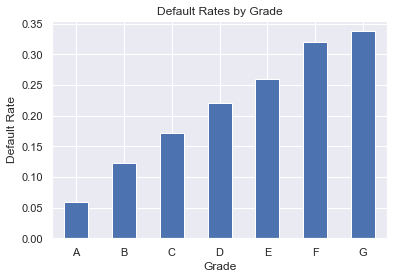

In [147]:
# Plot of the default rate of each group. 
_ = df1.groupby('grade').mean()['loan_status'].plot(kind='bar', title= 'Default Rates by Grade')
_ = plt.xlabel('Grade')
_ = plt.ylabel('Default Rate')
_ = plt.xticks(rotation=360)
plt.show()

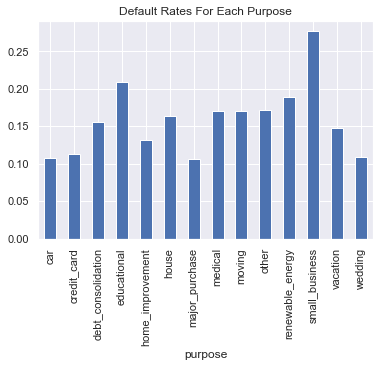

In [148]:
# Default rates were purpose
dr_of_each_purpose = df1.groupby('purpose').mean()['loan_status'].plot(kind='bar', \
                                                                       title = 'Default Rates For Each Purpose')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

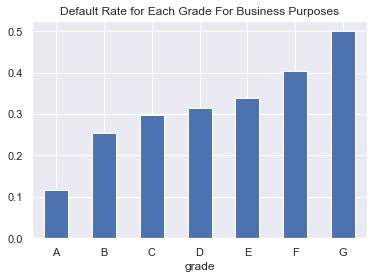

In [149]:
# Default rates of business purpose loans by grade
dr_of_each_grade_of_each_purpose = \
df1.loc[df1['purpose']=='small_business'].groupby('grade').mean()['loan_status'].plot(kind='bar', \
                             title = 'Default Rate for Each Grade For Business Purposes') 
plt.xticks(rotation=360)

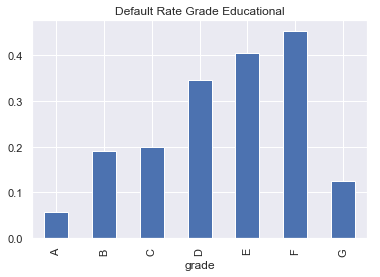

In [150]:
# Defaults rates for educational purpose loans by grade
df1.loc[df1['purpose']=='educational'].groupby('grade').mean()['loan_status'].plot(kind='bar', title = \
                                                                                  'Default Rate Grade Educational')

Text(0.5, 1.0, 'Debt to Inome Dist.')

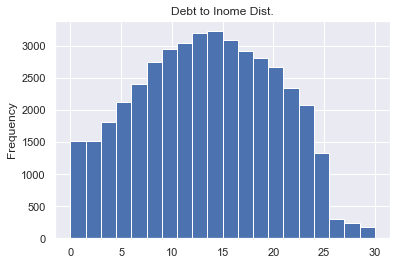

In [151]:
# Distribution of the debt to income ratios. 
df1.dti.plot(kind='hist', bins=20)
plt.title('Debt to Inome Dist.')

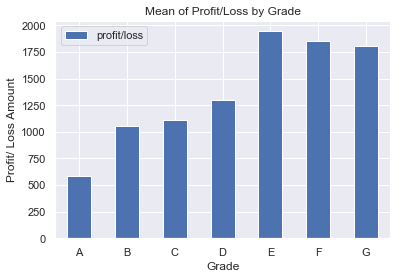

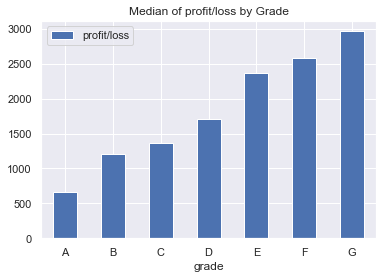

In [153]:
# Mean profit/losses vs Median by grade. It seems fairly even.
mean = df1[['profit/loss','grade']].groupby('grade').mean().plot(kind='bar',\
                                                                 title='Mean of Profit/Loss by Grade')
plt.xticks(rotation=360)
plt.xlabel('Grade')
plt.ylabel('Profit/ Loss Amount')
mean.set_xticklabels(['A','B','C','D','E','F','G'])
median = df1[['profit/loss','grade']].groupby('grade').median().plot(kind='bar',\
                                                                     title='Median of profit/loss by Grade')
plt.xticks(rotation=360)
median.set_xticklabels(['A','B','C','D','E','F','G'])
plt.show()

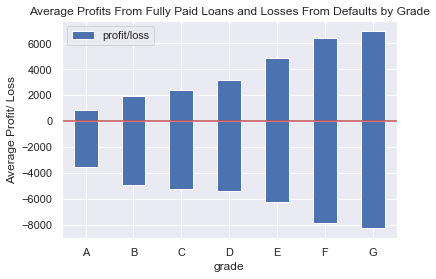

In [154]:
# Comparing AVERAGE gains and losses by grade. Are the extra risks worth the extra rewards?
ax = plt.gca()
_  = df1[['profit/loss','grade']].loc[df1['loan_status']==0].groupby('grade').mean()\
.plot(kind='bar', title = "Average Profits From Fully Paid Loans and Losses From Defaults by Grade", legend = None, ax=ax)
_.set_xticklabels(['A','B','C','D','E','F','G'])
_ = plt.xlabel('Grade')
_ = plt.ylabel('Average Profit/ Loss')
_ = df1[['profit/loss','grade']].loc[df1['loan_status']==1].groupby('grade').mean().\
plot(kind='bar', ax=ax)
_.set_xticklabels(['A','B','C','D','E','F','G'])
_ = plt.axhline(y=0, color='r', linestyle='-')
_ = plt.xticks(rotation=360)
plt.show()

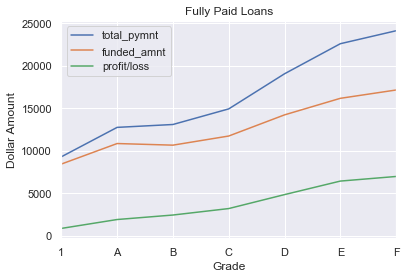

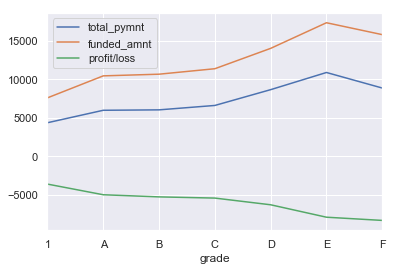

In [156]:
# Average total loan payments, funded amounts, their differences (profits/losses), plotted by grade. 
fullypaidcashflows = df1.loc[df1['loan_status']==0].groupby('grade').mean()[['total_pymnt','funded_amnt', 'profit/loss']].plot(title='Fully Paid Loans')
fullypaidcashflows.set_xticklabels([1,'A','B','C','D','E','F','G'])
plt.xlabel('Grade')
plt.ylabel('Dollar Amount')
defaultcashflows = df1.loc[df1['loan_status']==1].groupby('grade').mean()[['total_pymnt','funded_amnt', 'profit/loss']].plot()
defaultcashflows.set_xticklabels([1,'A','B','C','D','E','F','G'])
plt.show()

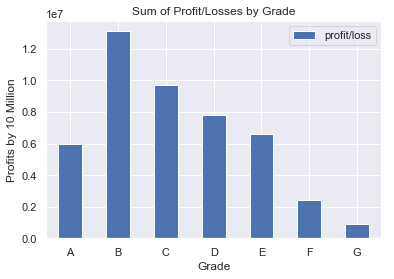

In [157]:
# Sum of all profits and losses by grade. 
_ = df1[['profit/loss', 'grade']].groupby('grade').sum().plot(kind='bar', title='Sum of Profit/Losses by Grade')
_ = plt.xlabel('Grade')
_ = plt.ylabel('Profits by 10 Million')
_ = plt.xticks(rotation=360)
plt.show()

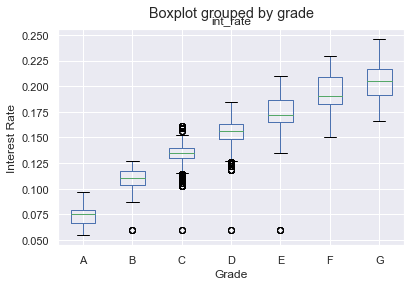

In [161]:
# Distributions of interest rates per grade
df1.boxplot(column = 'int_rate', by= 'grade')
plt.xlabel('Grade')
plt.ylabel('Interest Rate')
plt.show()

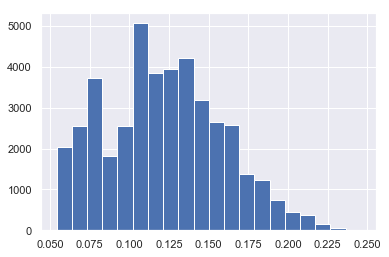

In [169]:
# Dsitribution of interest rates
plt.hist(df1['int_rate'], bins=20)
plt.show()

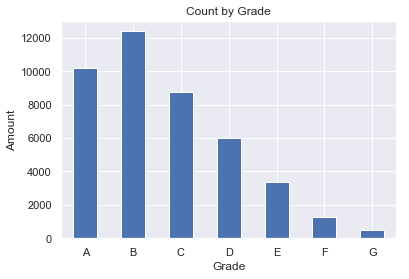

In [158]:
# Total amount of loans of each grade
_ = df1[['term','grade']].groupby('grade').count().plot(kind= 'bar', title= "Count by Grade", legend = None)
_ = plt.xlabel('Grade')
_ = plt.ylabel('Amount')
_ = plt.xticks(rotation=360)


plt.show()

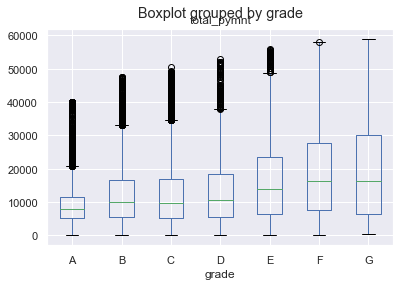

In [163]:
# Total payments of loans for each grade
df1.boxplot(column = 'total_pymnt', by= 'grade')
plt.show()

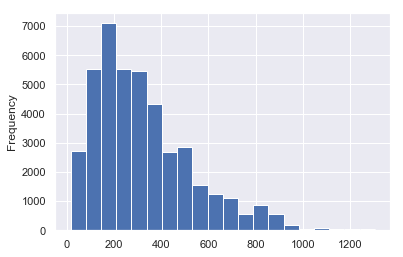

In [164]:
# Distribution of installment
df1.installment.plot(kind='hist', bins = 20)

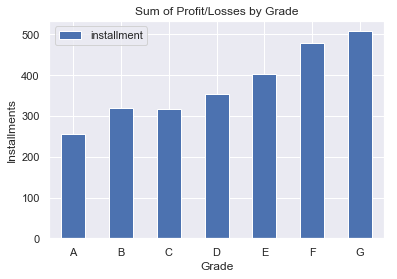

In [171]:
# Sum of all profits and losses by grade. 
_ = df1[['installment', 'grade']].groupby('grade').mean().plot(kind='bar', title='Sum of Profit/Losses by Grade')
_ = plt.xlabel('Grade')
_ = plt.ylabel('Installments')
_ = plt.xticks(rotation=360)
plt.show()

In [172]:
# Creating variable called real margins. The percentage of the total gains and losses for grade 
fa = df1.groupby('grade').sum()['funded_amnt']
pl = df1.groupby('grade').sum()['profit/loss']
realmargins = pl/fa

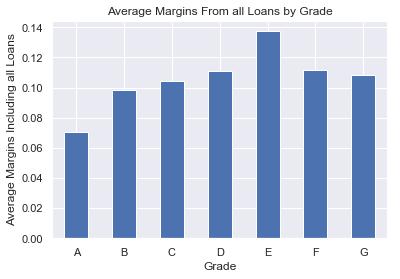

In [173]:
# Adding up all profits/ losses and funded amount of each grade and dividing them to get the total margins for
# each grade
_ = realmargins.plot(kind='bar')
_ = plt.xlabel('Grade')
_ = plt.ylabel('Average Margins Including all Loans')
_ = plt.title('Average Margins From all Loans by Grade')
_ = plt.xticks(rotation=360)
plt.show()

In [174]:
# Creating variables of total margins for each grade splitting them into fully paid and defaulted loans. 
# Getting the total profit margins from fully paid loans and loss percentages for each grade
fpfa = df1.loc[df1['loan_status']==0].groupby('grade').sum()['funded_amnt']
fppl = df1.loc[df1['loan_status']==0].groupby('grade').sum()['profit/loss']
fprealmargins = fppl/fpfa
dfa = df1.loc[df1['loan_status']==1].groupby('grade').sum()['funded_amnt']
dpl = df1.loc[df1['loan_status']==1].groupby('grade').sum()['profit/loss']
defaultmargins = dpl/ dfa

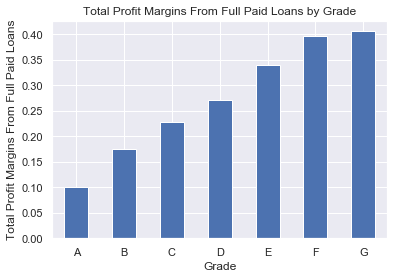

In [176]:
# Total profit margins by grade
_ = fprealmargins.plot(kind='bar')
_ = plt.xlabel('Grade')
_ = plt.ylabel('Total Profit Margins From Full Paid Loans')
_ = plt.title('Total Profit Margins From Full Paid Loans by Grade')
_ = plt.xticks(rotation=360)
plt.show()

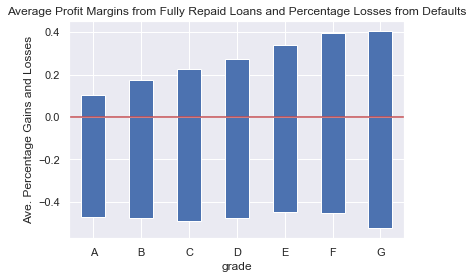

In [177]:
# Comparing total profit margins from fully repaid loans to total loss percentage from defaults for each grade
ax = plt.gca()
_  = fprealmargins\
.plot(kind='bar', title = "Average Profit Margins from Fully Repaid Loans and Percentage Losses from Defaults", legend = None, ax=ax)
_.set_xticklabels(['A','B','C','D','E','F','G'])
_ = plt.xlabel('Grade')
_ = plt.ylabel('Ave. Percentage Gains and Losses')
_ = defaultmargins.\
plot(kind='bar', ax=ax)
_.set_xticklabels(['A','B','C','D','E','F','G'])
_ = plt.axhline(y=0, color='r', linestyle='-')
_ = plt.xticks(rotation=360)
plt.show()

# Inferential Statistics

In [178]:
def gradevariable(letter, variable):
    """Get grade and variable"""
    gradevariablearray = df1.loc[df1['grade']==letter][variable]
    return gradevariablearray

In [179]:
def obs_diff_means(data1, data2):
    """difference of means between observed means"""
    diff_mean = np.mean(data1)-np.mean(data2)
    return diff_mean

In [180]:
def p_value(letter1, letter2, variable):
    """To get p value to test difference in means and dist's"""
    
    array1 = gradevariable(letter1, variable)
    array2 = gradevariable(letter2, variable)
    
    diffmeans = obs_diff_means(array1, array2)
    
    perm_replicates = np.empty(10000)
    for i in range(10000):
        concat = np.concatenate((array1, array2))
        perm_data = np.random.permutation(concat)
        perm_sample1 = perm_data[:len(array1)]
        perm_sample2 = perm_data[len(array1):]
        perm_replicates[i] = np.mean(perm_sample1) - np.mean(perm_sample2)
        
    if diffmeans < 0:
        p_value = np.sum(perm_replicates <= diffmeans)/len(perm_replicates)
    else:
        p_value = np.sum(perm_replicates >= diffmeans)/len(perm_replicates)
        
    print(letter1, letter2, p_value)

In [181]:
def bs_rep_variable(gradevariablearray):
    """Get the BS reps for grade and variable"""
    bs_replicates_obs = np.empty(10000)
    for i in range(10000):
        bs_replicates_obs[i]=np.mean(np.random.choice(gradevariablearray, len(gradevariablearray)))
    return bs_replicates_obs

In [182]:
def allfuncplt(letter1, letter2, variable):
    """To plot dist of BS_reps to compare respective dist's"""
    
    array1 = gradevariable(letter1, variable)
    array2 = gradevariable(letter2, variable)

    samplemeans1 = bs_rep_variable(array1)
    samplemeans2 = bs_rep_variable(array2)

    _ = plt.hist(samplemeans1, bins=20, alpha = .7)
    _ = plt.hist(samplemeans2, bins=20, alpha = .7)
    plt.show()

In [183]:
# P values of differences in dist of default rates per grade. 
for a in ['B','C','D','E','F','G']:
    p_value('A',a, 'loan_status')
for b in ['C','D','E','F','G']:
    p_value('B',b, 'loan_status')
for c in ['D','E','F','G']:
    p_value('C',c, 'loan_status')
for d in ['E','F','G']:
    p_value('D',d, 'loan_status')
for e in ['F','G']:
    p_value('E',e, 'loan_status')
for f in ['G']:
    p_value('F',f, 'loan_status')

A B 0.0
A C 0.0
A D 0.0
A E 0.0
A F 0.0
A G 0.0
B C 0.0
B D 0.0
B E 0.0
B F 0.0
B G 0.0
C D 0.0
C E 0.0
C F 0.0
C G 0.0
D E 0.0
D F 0.0
D G 0.0
E F 0.0
E G 0.0006
F G 0.2452


In [184]:
def pvaluefunk(variable):
    """Get p values between every grade"""
    for a in ['B','C','D','E','F','G']:
        p_value('A',a, variable)
    for b in ['C','D','E','F','G']:
        p_value('B',b, variable)
    for c in ['D','E','F','G']:
        p_value('C',c, variable)
    for d in ['E','F','G']:
        p_value('D',d, variable)
    for e in ['F','G']:
        p_value('E',e, variable)
    for f in ['G']:
        p_value('F',f, variable)

In [185]:
# P values for interest rate differences of dist. between grades. Null is that
pvaluefunk('int_rate')

A B 0.0
A C 0.0
A D 0.0
A E 0.0
A F 0.0
A G 0.0
B C 0.0
B D 0.0
B E 0.0
B F 0.0
B G 0.0
C D 0.0
C E 0.0
C F 0.0
C G 0.0
D E 0.0
D F 0.0
D G 0.0
E F 0.0
E G 0.0
F G 0.0


In [186]:
# P values of differences in dist. of margins between grades grade. 
pvaluefunk('margins')

A B 0.0
A C 0.0
A D 0.0
A E 0.0
A F 0.0
A G 0.0004
B C 0.1336
B D 0.0088
B E 0.0
B F 0.0333
B G 0.4674
C D 0.1221
C E 0.0
C F 0.1458
C G 0.4098
D E 0.0028
D F 0.3699
D G 0.2814
E F 0.0962
E G 0.0562
F G 0.287
